# ribo-gcamp

In [327]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sc
from scipy.spatial import distance
from scipy import optimize


## create synthetic ribo-gcamp ramp trace generator

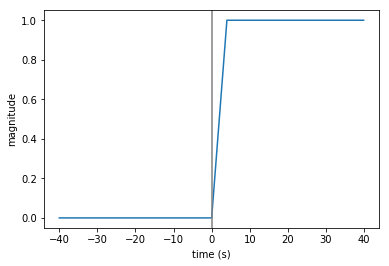

In [149]:
time_vec=np.arange(-40,40,0.1)

def gen_ribo_trace(rise_time,in_time_vec):
    out_vec=np.zeros(len(time_vec))
    for i in range(len(time_vec)):
        if in_time_vec[i]>0:
            if in_time_vec[i]<rise_time:
                out_vec[i]=in_time_vec[i]/rise_time
            else:
                out_vec[i]=1.0
                                   
    return out_vec 

fig, ax = plt.subplots()
plt.plot(time_vec,gen_ribo_trace(4.0,time_vec))
plt.xlabel("time (s)")
plt.ylabel("magnitude")
ax.axvline(x=0, color='gray')
plt.show()

## create first-order impulse response function


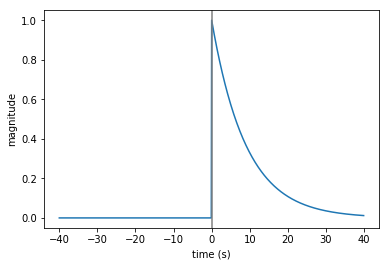

In [188]:
def gen_irf(tau,in_time_vec):
    out_vec=np.zeros(len(time_vec))
    for i in range(len(time_vec)):
        if in_time_vec[i]>0:
                out_vec[i]=np.exp(-in_time_vec[i]/tau)
    return out_vec

fig, ax = plt.subplots()
plt.plot(time_vec,gen_irf(9.0,time_vec))
plt.xlabel("time (s)")
plt.ylabel("magnitude")
ax.axvline(x=0, color='gray')
plt.show()

## create nls trace generator as convolution of ribo-gcamp traces and irf

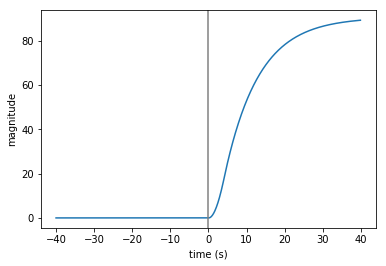

In [203]:
def gen_nls_trace(rise_time,tau,in_time_vec):   
    convolved_vec=np.convolve(gen_ribo_trace(rise_time,in_time_vec),gen_irf(tau,in_time_vec),mode='same') 
    out_vec=convolved_vec
    return out_vec


fig, ax = plt.subplots()
plt.plot(time_vec,gen_nls_trace(4.0,9.0,time_vec))
plt.xlabel("time (s)")
plt.ylabel("magnitude")
ax.axvline(x=0, color='gray')
plt.show()

## measure rise time of trace

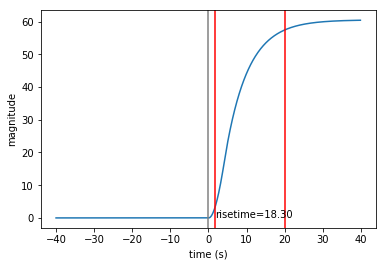

In [249]:
def measure_rise_time(trace,in_time_vec,threshold_low=0.05,threshold_high=0.95):
    
    # find start time
    start_time=in_time_vec[np.argmax(trace > (max(trace)-min(trace))*threshold_low+min(trace))]
    
    # find end time
    end_time=in_time_vec[np.argmax(trace > (max(trace)-min(trace))*threshold_high+min(trace))]

    rise_time = end_time - start_time
    return rise_time, start_time, end_time
 
    
test_trace=gen_nls_trace(4.0,6.0,time_vec)       
test_rise_time, test_start_time, test_end_time = measure_rise_time(test_trace,time_vec)
    
fig, ax = plt.subplots()
plt.plot(time_vec,gen_nls_trace(4.0,6.0,time_vec))
plt.text(test_start_time, 0, 'risetime={:.2f}'.format(test_rise_time))
plt.xlabel("time (s)")
plt.ylabel("magnitude")
ax.axvline(x=0, color='gray')
ax.axvline(x=test_start_time, color='red')
ax.axvline(x=test_end_time, color='red')
plt.show()

## transform ribo-gcamp rise times into nls-gcamp rise times given an i.r.f. tau

In [364]:
def transform_rise_times(ribo_vec,tau):
    
    this_time_vec=np.arange(-40,40,0.1)
    nls_vec=[]
    
    for time in ribo_vec:
        rt, _, _ = measure_rise_time(gen_nls_trace(time,tau,this_time_vec),this_time_vec,
                                     threshold_low=0.05,threshold_high=0.99)
        nls_vec = np.append(nls_vec,rt)
    
    return nls_vec


## create synthetic test data

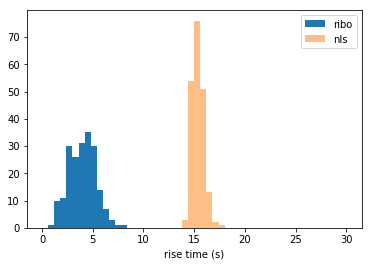

In [369]:
test_ribo=abs((np.random.randn(200)*1.3)+4)

test_nls=transform_rise_times(test_ribo,tau=3.1)

_, bins, _ = plt.hist(test_ribo,range=[0, 30],bins=50,label='ribo')
_ = plt.hist(test_nls,range=[0, 30],bins=bins,label='nls',alpha=0.5)
plt.legend(loc='upper right')
plt.xlabel("rise time (s)")
plt.show()

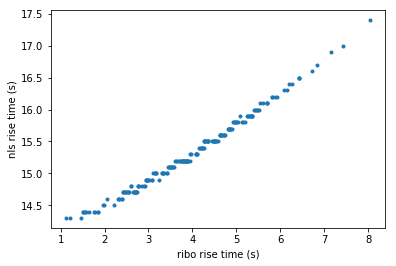

In [370]:
plt.plot(test_ribo,test_nls,'.')
plt.xlabel("ribo rise time (s)")
plt.ylabel("nls rise time (s)")
plt.show()

## define histogram-comparison error function

In [367]:
def error_func(tau,vec1,vec2,num_bins=30,range=[0, 20]):
    
    # make hist
    hist_exper=np.histogram(vec2,bins=num_bins,range=range)
    
    # transform rise_times
    vec2_model = transform_rise_times(vec1,tau)
    hist_model=np.histogram(vec2_model,bins=num_bins,range=range)
    
    # compare hists
    err=distance.euclidean(hist_exper[0],hist_model[0])
    return err 

## find tau that best explains data

In [371]:
res=optimize.minimize(error_func,2.5,args=(test_ribo, test_nls),method='nelder-mead',options={'disp': True})
res.x[0]

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 15
         Function evaluations: 34


3.099609375

## plot tau error landscape

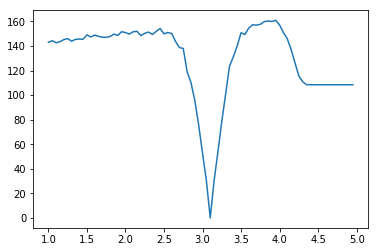

In [368]:
my_tau_vec = np.arange(1,5,0.05)
my_error_vec = []
for my_tau in my_tau_vec:
    my_error_vec=np.append(my_error_vec,error_func(my_tau,test_ribo,test_nls))
    
plt.plot(my_tau_vec,my_error_vec)    
plt.show()